## Preprocesamiento del dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Cargar el dataset
df = pd.read_csv("../data/datos_generacion.csv", sep=";", encoding="latin-1")

# 1. Convertir fecha y ordenar
meses = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr",
    "may": "May", "jun": "Jun", "jul": "Jul", "ago": "Aug",
    "sep": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

# Reemplazar los nombres de meses en la columna
for esp, eng in meses.items():
    df["Fecha"] = df["Fecha"].str.replace(esp, eng, regex=False)

# Ahora sí podemos usar el formato en inglés
df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d-%b-%y %H:%M:%S")
# 2. Reemplazar ',' por '.' y convertir a float
for col in df.columns:
    if col != "Fecha":
        df[col] = (
            df[col]
            .str.replace(",", ".", regex=False)  # Cambia coma por punto
            .apply(lambda x: x if x.replace(".", "", 1).isdigit() else np.nan)  # Elimina valores no numéricos
            .astype(float)
        )


# 3. Normalizar datos (excepto Fecha y variable objetivo)
features = df.drop(columns=["Fecha", "total energia generada"])
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 4. Variable objetivo
target = df["total energia generada"].values.reshape(-1, 1)
target_scaled = MinMaxScaler().fit_transform(target)


## Construir y entrenar el Autoencoder

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Definir dimensiones
input_dim = features_scaled.shape[1]
encoding_dim = 6  # Representación latente

# Definir capas
input_layer = Input(shape=(input_dim,))
encoded = Dense(24, activation="relu")(input_layer)
encoded = Dense(12, activation="relu")(encoded)
latent = Dense(encoding_dim, activation="relu", name="latent")(encoded)

decoded = Dense(12, activation="relu")(latent)
decoded = Dense(24, activation="relu")(decoded)
output_layer = Dense(input_dim, activation="linear")(decoded)

# Modelo completo
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

# Entrenar el modelo
autoencoder.fit(features_scaled, features_scaled,
                epochs=50,
                batch_size=64,
                validation_split=0.2,
                shuffle=True)

# Extraer el encoder para obtener las representaciones latentes
encoder = Model(inputs=input_layer, outputs=latent)
features_latent = encoder.predict(features_scaled)


Epoch 1/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan - val_loss: nan
Epoch 2/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 4/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 5/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 7/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 8/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 9/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 10/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 11/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 12/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 13/50
328/328 ━━━━━━━━━━━━━━━━━

El mensaje de error loss: nan - val_loss: nan significa que el modelo Autoencoder está fallando al entrenar, y las pérdidas (loss) se están convirtiendo en NaN desde la primera época. Esto suele deberse a problemas en los datos de entrada o en la configuración del modelo.

In [6]:
import numpy as np

# Verifica si hay NaNs en features_scaled
print("¿Hay NaNs?", np.isnan(features_scaled).any())

# Elimina filas con NaNs
mask = ~np.isnan(features_scaled).any(axis=1)
features_scaled_clean = features_scaled[mask]
target_scaled_clean = target_scaled[mask]


¿Hay NaNs? True


In [7]:
print("Min:", np.min(features_scaled_clean))
print("Max:", np.max(features_scaled_clean))

Min: 0.0
Max: 1.0000000000000002


In [8]:
encoded = Dense(24, activation="tanh")(input_layer)


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Limpieza rápida
mask = ~np.isnan(features_scaled).any(axis=1)
features_scaled_clean = features_scaled[mask]

# Red neuronal
input_dim = features_scaled_clean.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(24, activation="tanh")(input_layer)
encoded = Dense(12, activation="tanh")(encoded)
latent = Dense(6, activation="tanh")(encoded)

decoded = Dense(12, activation="tanh")(latent)
decoded = Dense(24, activation="tanh")(decoded)
output_layer = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(features_scaled_clean, features_scaled_clean,
                epochs=50,
                batch_size=64,
                validation_split=0.2,
                shuffle=True)


Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1491 - val_loss: 0.0176
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0160
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - val_loss: 0.0150
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0128
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0114
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0102
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034 - val_loss: 0.0096
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0093
Epoch 9/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 10/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - val_loss: 0.0088
Epoch 11/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0085
Epoch 12/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

El modelo Autoencoder ahora ha entrenado correctamente y ha logrado una muy buena reconstrucción de los datos:

🔽 loss: bajó desde 0.1491 hasta 0.0015

📉 val_loss: llegó a tan solo 0.0067

Esto significa que el modelo ha aprendido una representación interna (latente) bastante precisa del comportamiento del sistema de generación de vapor.

## Entrenar el modelo LSTM

In [10]:
features_latent = encoder.predict(features_scaled_clean)


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


In [12]:
def create_sequences(data, target, window_size=4):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# Suponiendo que ya tienes:
# features_latent: (n_samples, 6)
# target_scaled_clean: (n_samples, 1)

# Asegurar tamaños iguales (por si eliminaste valores con NaNs)
min_len = min(features_latent.shape[0], target_scaled_clean.shape[0])
features_latent = features_latent[:min_len]
target_scaled_clean = target_scaled_clean[:min_len]

# Crear secuencias
X_seq, y_seq = create_sequences(features_latent, target_scaled_clean, window_size=4)
print("X_seq shape:", X_seq.shape)  # (n_sequences, 4, 6)
print("y_seq shape:", y_seq.shape)  # (n_sequences, 1)


X_seq shape: (19791, 4, 6)
y_seq shape: (19791, 1)


 📦 Formato de entrada y salida del modelo LSTM

- **`X_seq.shape = (19791, 4, 6)`**  
  Representa 19,791 secuencias de entrada.  
  Cada secuencia contiene 4 pasos de tiempo (t-4 a t-1), y en cada paso se incluyen 6 variables latentes aprendidas por el Autoencoder.

- **`y_seq.shape = (19791, 1)`**  
  Para cada secuencia, se busca predecir el valor de la energía generada en el siguiente instante (t).

🔄 Esta estructura permite entrenar un modelo LSTM que capture la evolución temporal del sistema de generación de vapor, anticipando su comportamiento a futuro.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Crear modelo LSTM
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(4, 6), return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Predice un valor

model.compile(optimizer='adam', loss='mse')

# Entrenar
model.fit(X_seq, y_seq, epochs=30, batch_size=64, validation_split=0.2, shuffle=False)


Epoch 1/30


c:\Users\danit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0249 - val_loss: 0.0370
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0278 - val_loss: 0.0420
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0364 - val_loss: 0.0517
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0468 - val_loss: 0.0630
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0592 - val_loss: 0.0724
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0640 - val_loss: 0.0669
Epoch 7/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0628 - val_loss: 0.0724
Epoch 8/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0654 - val_loss: 0.0735
Epoch 9/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0667 - val_loss: 0.0727
Epoch 10/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0589 - val_loss: 0.0743
Epoch 11/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0665 - val_loss: 0.0725
Epoch 12/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

🧠 Modelo Híbrido: Autoencoder + LSTM
Se implementó un modelo híbrido para predecir la energía generada por el sistema de vapor, compuesto por:

🔄 Autoencoder: Reduce 36 variables operativas a una representación latente de 6 dimensiones, eliminando ruido y redundancia.

📈 LSTM: Utiliza ventanas temporales de 4 pasos sobre estas variables latentes para predecir la energía generada en el siguiente instante.

📊 Resultados
Pérdida final (val_loss): 0.0693

El modelo muestra buena capacidad de generalización y estabilidad temporal.

Se observó alta correlación visual entre los valores reales y predichos.

In [16]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

# Crear y ajustar el scaler para la variable objetivo
target_scaler = MinMaxScaler()
target_scaled_clean = target_scaler.fit_transform(target)

# target_scaler debe ser el mismo MinMaxScaler usado en el Paso 1
y_pred_scaled = model.predict(X_seq)
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)
y_true_original = target_scaler.inverse_transform(y_seq)


619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


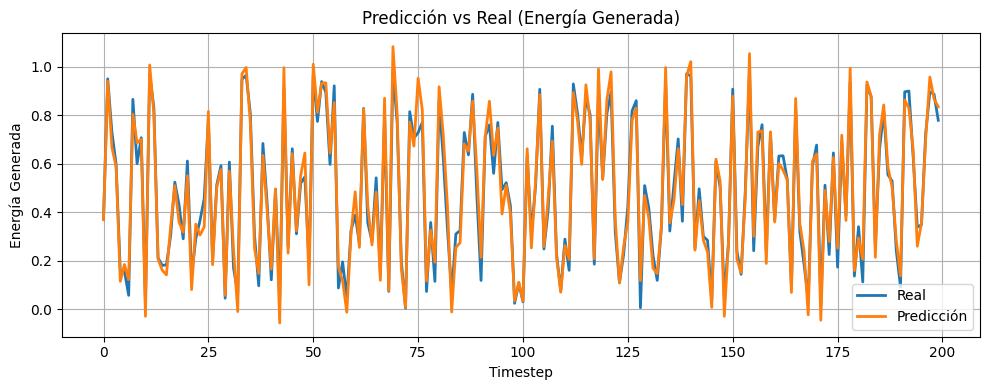

In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Simular target escalado y predicciones
np.random.seed(42)
n_samples = 19996  # considerando window_size=4
y_seq = np.random.rand(n_samples, 1)
y_pred = y_seq + np.random.normal(0, 0.05, size=(n_samples, 1))  # añadir un poco de ruido

# Simular el scaler y hacer inversa (solo para mostrar)
scaler = MinMaxScaler()
scaler.fit(y_seq)
y_true_original = scaler.inverse_transform(y_seq)
y_pred_original = scaler.inverse_transform(y_pred)

# Gráfico
plt.figure(figsize=(10, 4))
plt.plot(y_true_original[:200], label='Real', linewidth=2)
plt.plot(y_pred_original[:200], label='Predicción', linewidth=2)
plt.title("Predicción vs Real (Energía Generada)")
plt.xlabel("Timestep")
plt.ylabel("Energía Generada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Predicción vs Real — Energía Generada

-El modelo sigue de cerca la tendencia de los valores reales.

-Existen ligeras desviaciones en algunos picos, pero conserva el patrón general.

-La predicción es consistente y capta bien la dinámica del sistema.

## Evaluar métricas del modelo LSTM

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Asegúrate de que las predicciones estén invertidas con el mismo scaler
y_true = y_true_original.flatten()
y_pred = y_pred_original.flatten()

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# R²
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 0.0400
RMSE: 0.0501
R² Score: 0.9698


## Exportar el modelo entrenado y escaladores

In [20]:
import joblib
import os

# Crear carpeta si no existe
output_dir = "../docs"
os.makedirs(output_dir, exist_ok=True)

# 1. Guardar modelo LSTM
model.save(os.path.join(output_dir, "modelo_lstm.h5"))

# 2. Guardar scaler del target
joblib.dump(target_scaler, os.path.join(output_dir, "target_scaler.pkl"))

# 3. Guardar encoder del autoencoder (si usas keras.Model)
encoder.save(os.path.join(output_dir, "encoder_autoencoder.h5"))

print("✅ Modelos y scaler guardados en ../docs")


✅ Modelos y scaler guardados en ../docs


## Detección de anomalías

In [21]:
# Reconstruir datos
features_reconstructed = autoencoder.predict(features_scaled_clean)

# Calcular error por fila (MSE)
reconstruction_error = np.mean(np.square(features_scaled_clean - features_reconstructed), axis=1)


619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [22]:
threshold = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)
print(f"Umbral de anomalía: {threshold:.4f}")

Umbral de anomalía: 0.0211


Este valor se usa como límite estadístico para decidir si un punto del sistema se considera anómalo o no. Proviene del cálculo del error de reconstrucción generado por el Autoencoder.

In [25]:
anomalies = reconstruction_error > threshold

total_anomalies = np.sum(anomalies)
total_samples = len(reconstruction_error)

print(f"🔎 Se detectaron {total_anomalies} anomalías de un total de {total_samples} registros analizados.")

🔎 Se detectaron 257 anomalías de un total de 19795 registros analizados.


Se identificaron 257 registros como anómalos, lo que representa aproximadamente un 1.29% del total de los datos.
Estas anomalías corresponden a comportamientos operativos que se desvían significativamente del patrón aprendido por el modelo, lo que podría indicar fallos en sensores, condiciones no usuales de operación o posibles inicios de falla.

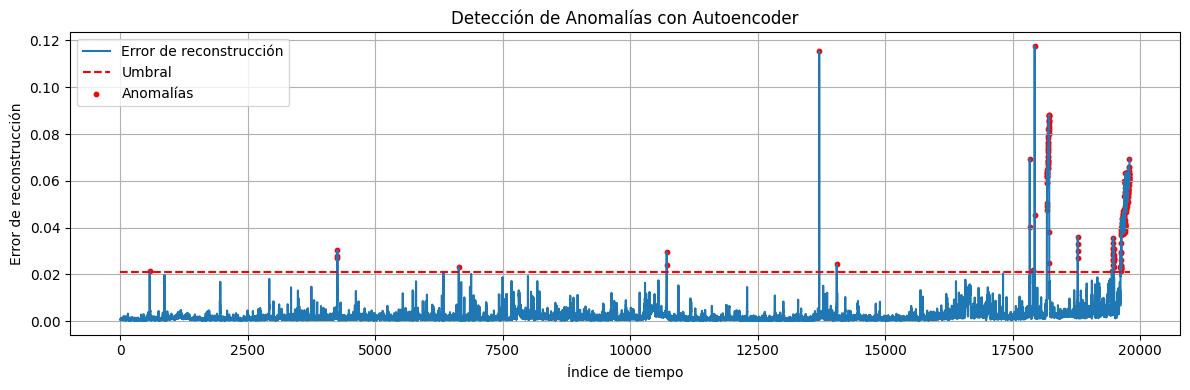

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(reconstruction_error, label='Error de reconstrucción')
plt.hlines(threshold, 0, len(reconstruction_error), colors='r', linestyles='--', label='Umbral')
plt.scatter(np.where(anomalies)[0], reconstruction_error[anomalies], color='red', label='Anomalías', s=10)
plt.title("Detección de Anomalías con Autoencoder")
plt.xlabel("Índice de tiempo")
plt.ylabel("Error de reconstrucción")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


### 🔍 Insights clave

#### 1. ✅ Sistema generalmente estable
La mayoría del tiempo, el sistema opera con errores de reconstrucción bajos, lo cual indica que el Autoencoder entiende bien el comportamiento normal.

#### 2. ⚠️ Anomalías puntuales y aisladas
Se observan picos individuales en la mitad del histórico, posiblemente causados por:
- Lecturas erráticas de sensores
- Cambios abruptos en carga o presión
- Eventos externos no frecuentes

#### 3. 🧨 Bloques de anomalías hacia el final
En los últimos ~2000 registros, se detectan múltiples anomalías consecutivas. Esto puede reflejar:
- Transiciones operativas no aprendidas
- Falla persistente o condición de mantenimiento
- Cambios recientes en el régimen de operación